In [1]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from relative_fitness_mechanisms import RelativeFitnessHSGP, SquaredExponential, Matern

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

In [3]:
raw_seq = pd.read_csv("../../evofr/test/testing_data/mlr-variant-counts.tsv", sep="\t")
raw_seq = raw_seq[raw_seq.location == "City0"]
raw_seq["sequences"] = raw_seq["sequences"]
data = ef.VariantFrequencies(raw_seq, pivot="C")

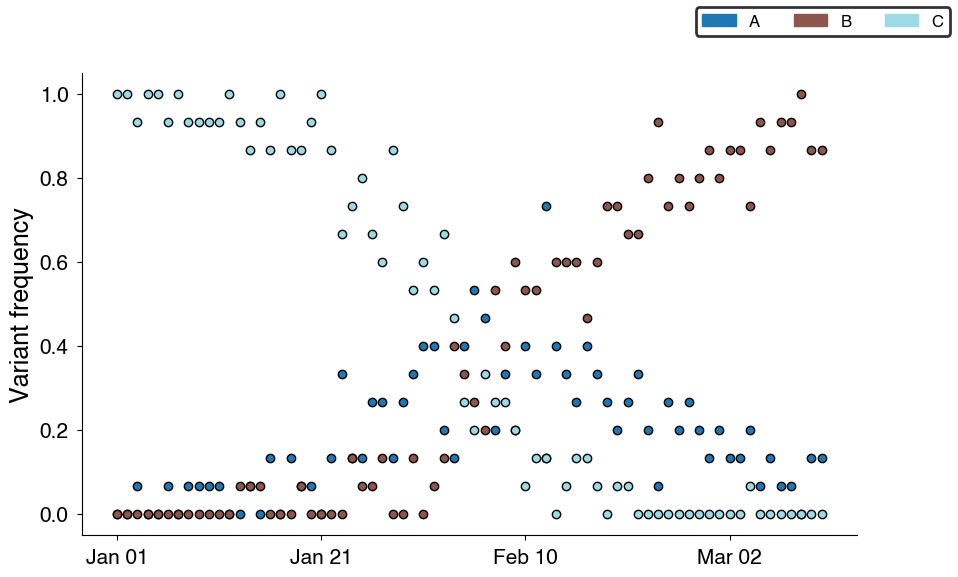

In [4]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, TimeVaryingPlot, PatchLegend

freq_plot = FrequencyPlot(data=data).plot(posterior=False);
PatchLegend(color_map=freq_plot.color_map).add_legend(ax=freq_plot.ax);

In [26]:
import numpyro.distributions as dist
from relative_fitness_mechanisms import SpectralMixture


hsgp_mat = Matern(
    L=140, 
    num_basis=35,
    rho = dist.HalfNormal(20),
    alpha = dist.HalfNormal(1e-3),
    nu=5/2)

hsgp_sq = SquaredExponential(
    L=140, 
    num_basis=35,
    rho = dist.HalfNormal(20),
    alpha = dist.HalfNormal(1e-3))


hsgp_sm = SpectralMixture(
    L=140,
    num_components=5)

model = RelativeFitnessHSGP(hsgp_mat) # Do I need to add intercepts?
inference_method = ef.InferNUTS(num_samples=500, num_warmup=3000)
#inference_method = ef.InferMAP(lr=4e-4, iters=50_000)

posterior = inference_method.fit(model, data=data)

sample: 100%|█| 3500/3500 [00:04<00:00, 841.07it/s, 63 steps of size 4.85e-02. a


In [27]:
posterior.samples.keys()

dict_keys(['alpha', 'beta', 'delta', 'freq', 'init_logit', 'intercept', 'rho', 'sqrt_spd', 'seq_counts'])

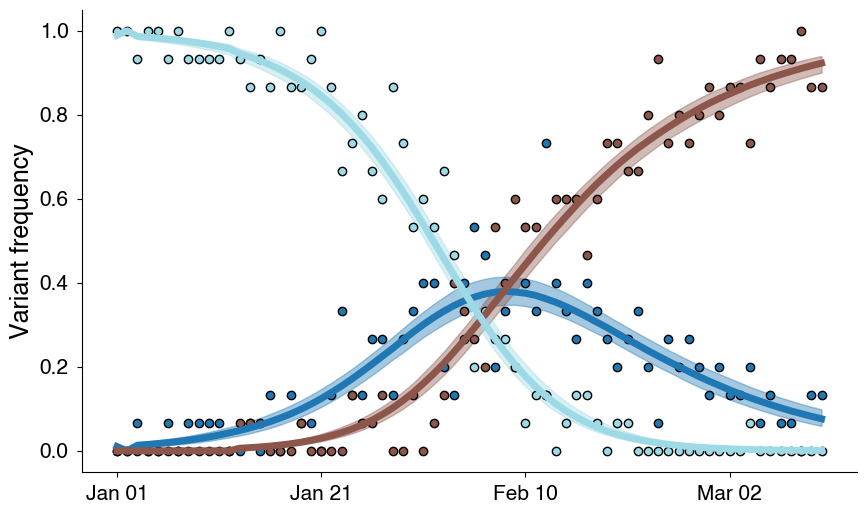

In [28]:
freq_plot = FrequencyPlot(posterior).plot();

In [29]:
import jax.numpy as jnp

In [30]:
posterior.samples = model.forecast_mcmc(posterior.samples, 14)

In [31]:
posterior.samples["freq_forecast"].shape

(500, 14, 3)

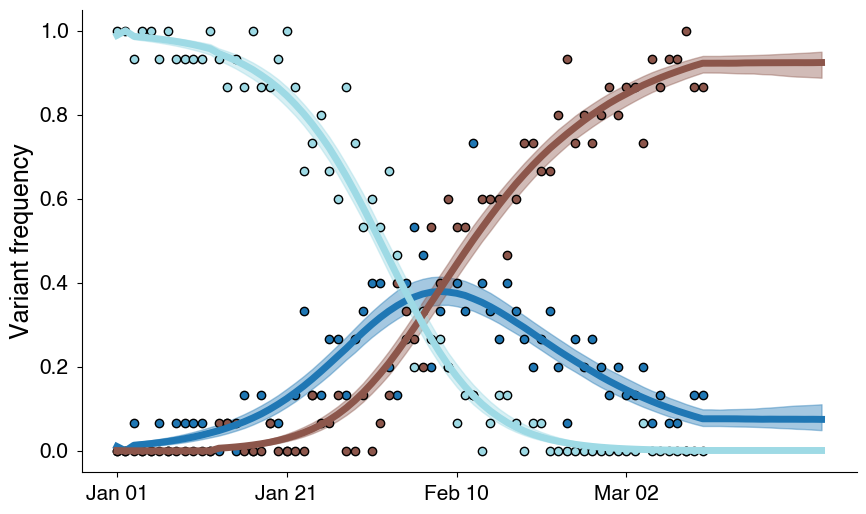

In [32]:
freq_plot = FrequencyPlot(posterior).plot(forecast=True);

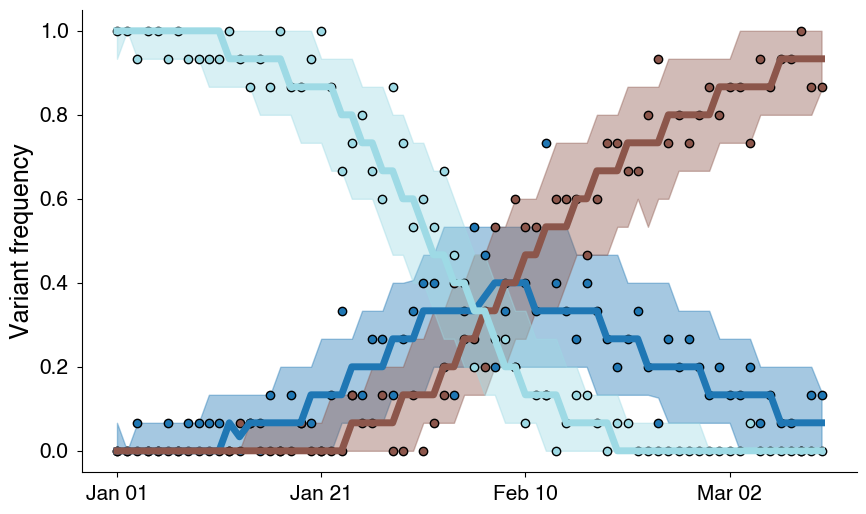

In [33]:
freq_plot = FrequencyPlot(posterior).plot(forecast=True, predictive=True, posterior=False);

Text(0, 0.5, 'Relative Fitness')

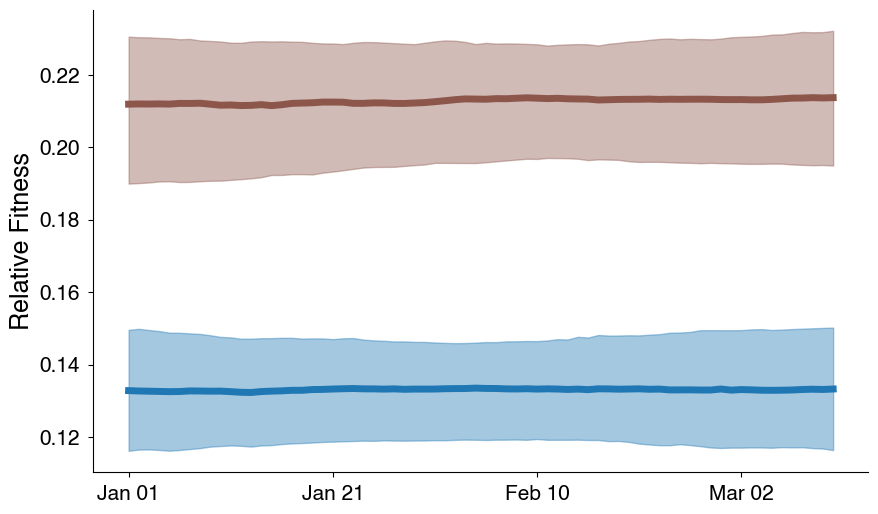

In [34]:
delta_plot = TimeVaryingPlot(posterior=posterior, site="delta").plot()
delta_plot.ax.set_ylabel("Relative Fitness")

Text(0, 0.5, 'Relative Fitness')

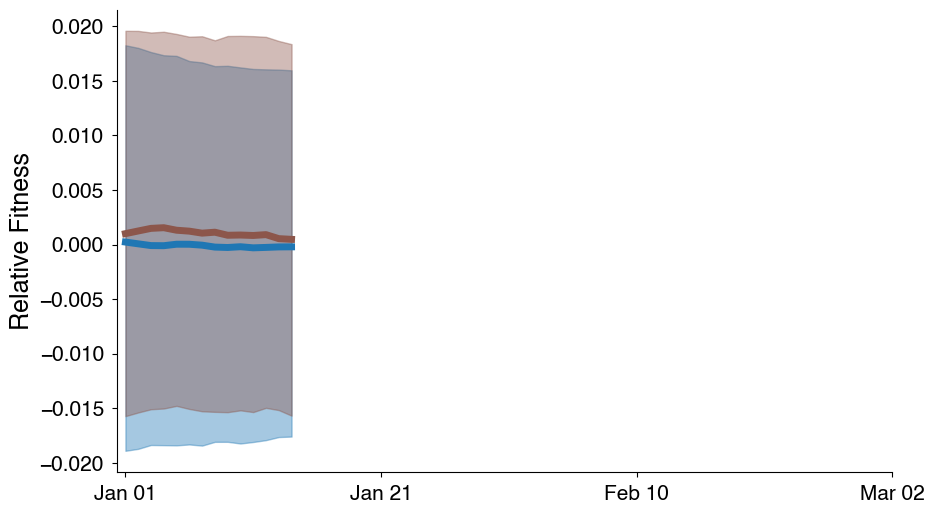

In [35]:
delta_plot = TimeVaryingPlot(posterior=posterior, site="delta_forecast").plot()
delta_plot.ax.set_ylabel("Relative Fitness")

In [36]:
posterior.samples.keys()

dict_keys(['alpha', 'beta', 'delta', 'freq', 'init_logit', 'intercept', 'rho', 'sqrt_spd', 'seq_counts', 'delta_forecast', 'freq_forecast'])

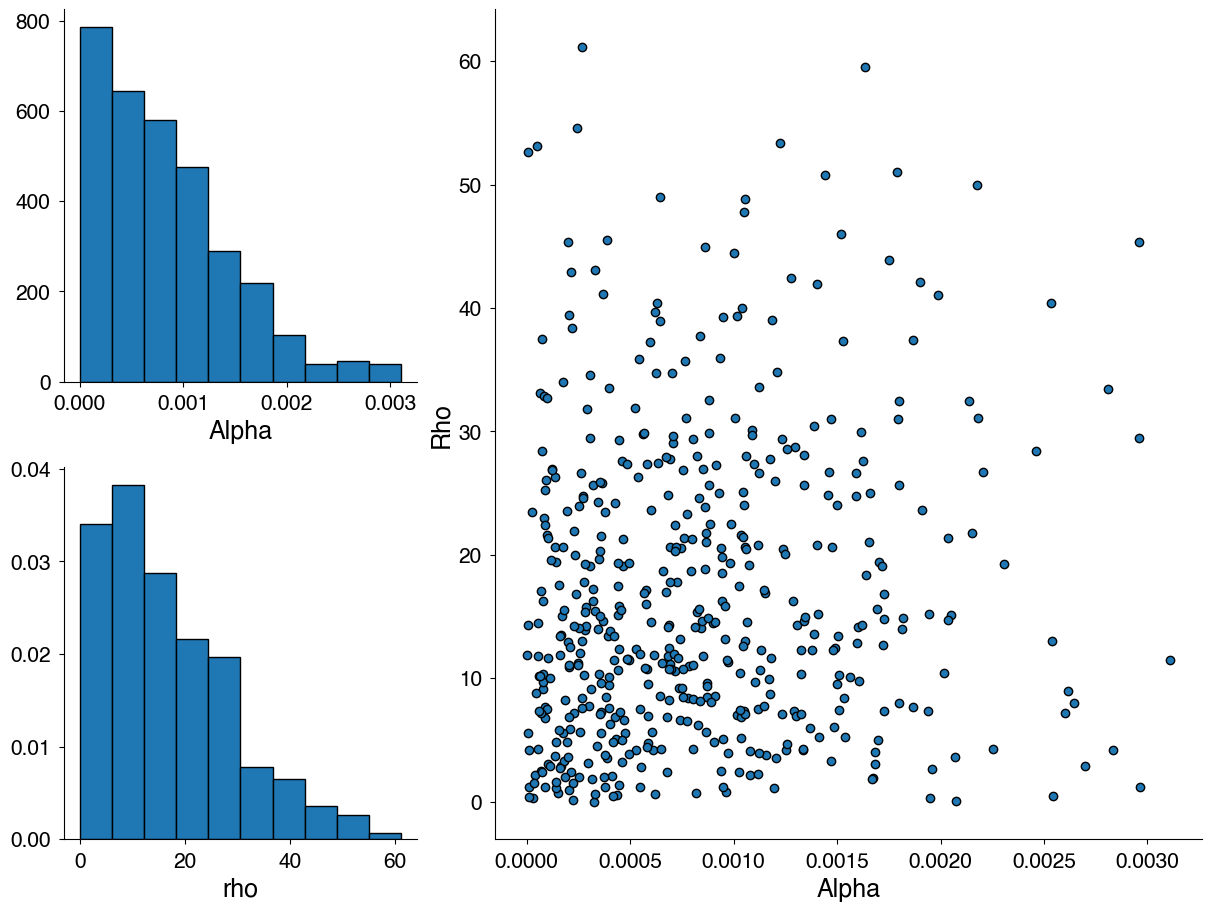

In [37]:
fig = plt.figure(figsize=(12., 9.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.2, 0.4])
ax = fig.add_subplot(spec[0,0])

if "alpha" in posterior.samples and "rho" in posterior.samples:
    ax.hist(posterior.samples["alpha"], ec="k", density=True)
    ax.set_xlabel("Alpha")

    ax = fig.add_subplot(spec[1,0])
    ax.hist(posterior.samples["rho"], ec="k", density=True)
    ax.set_xlabel("rho")

    ax = fig.add_subplot(spec[:,1])

    ax.scatter(posterior.samples["alpha"], posterior.samples["rho"], ec="k")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Rho")


Text(0, 0.5, 'Beta')

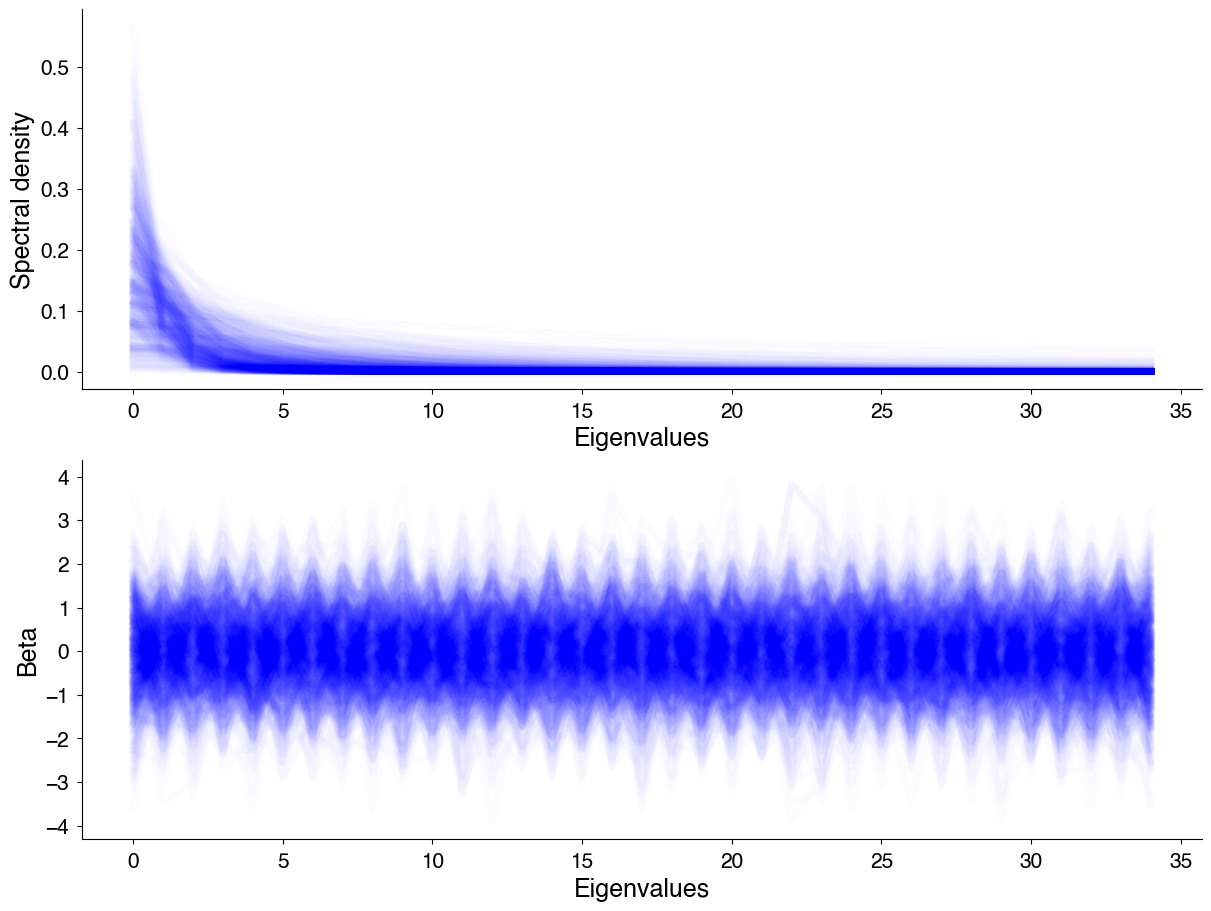

In [38]:
fig = plt.figure(figsize=(12., 9.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.2, 0.4])
ax = fig.add_subplot(spec[0,:])
ax.plot(posterior.samples["sqrt_spd"].T, color="b", alpha=0.01)
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Spectral density")


ax = fig.add_subplot(spec[1,:])
for v in range(posterior.samples["beta"].shape[-1]):
    ax.plot(posterior.samples["beta"][..., v].T, color="b", alpha=0.01)
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Beta")


In [39]:
plt.plot(posterior.samples["mixture_means"])

KeyError: 'mixture_means'

In [ ]:
posterior.samples["mixture_means"].shape

In [ ]:
fig = plt.figure(figsize=(12., 9.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=[0.2, 0.4])
ax = fig.add_subplot(spec[0,:])
ax.plot(posterior.samples["mixture_means"].T, color="b", alpha=0.01)
ax.set_ylabel("Mixture means")

ax = fig.add_subplot(spec[1,:])
ax.plot(posterior.samples["mixture_sigmas"].T, color="b", alpha=0.01)
ax.set_ylabel("Mixture sigmas")

ax = fig.add_subplot(spec[2,:])
ax.plot(posterior.samples["mixture_weights"].T, color="b", alpha=0.01)
ax.set_ylabel("Mixture weights")


In [40]:
posterior.samples["delta_forecast"].shape

(500, 14, 2)

(array([  29.,  265.,  834., 1447., 1764., 1718., 1451., 1078.,  646.,
         350.,  217.,  107.,   49.,   24.,   10.,    5.,    3.,    0.,
           0.,    3.]),
 array([ 22.23462868,  36.21570969,  50.19678879,  64.1778717 ,
         78.15895081,  92.14002991, 106.12110901, 120.10218811,
        134.08326721, 148.06434631, 162.04542542, 176.02650452,
        190.00758362, 203.98867798, 217.96975708, 231.95083618,
        245.93191528, 259.91299438, 273.89407349, 287.87515259,
        301.85623169]),
 <BarContainer object of 20 artists>)

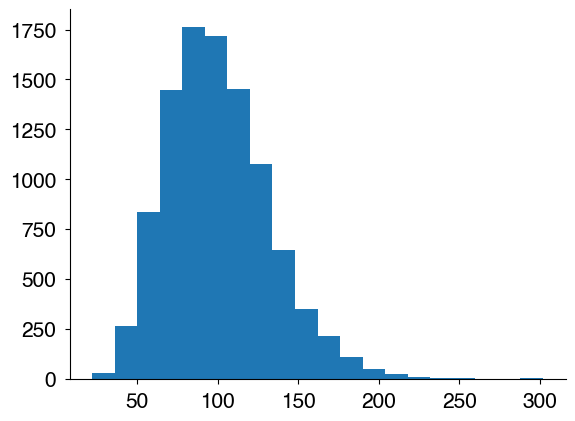

In [41]:
import numpyro.distributions as dist
from jax.random import PRNGKey

plt.hist(dist.Gamma(concentration=10, rate=0.1).sample(PRNGKey(1), sample_shape=(10000,)), bins=20)

(array([1.400e+01, 1.810e+02, 7.690e+02, 1.621e+03, 1.982e+03, 1.774e+03,
        1.363e+03, 9.700e+02, 5.910e+02, 3.350e+02, 1.830e+02, 1.020e+02,
        5.600e+01, 2.800e+01, 9.000e+00, 1.000e+01, 4.000e+00, 1.000e+00,
        3.000e+00, 4.000e+00]),
 array([0.438508  , 0.54811472, 0.6577214 , 0.76732808, 0.87693477,
        0.98654151, 1.09614813, 1.20575488, 1.31536162, 1.42496824,
        1.53457499, 1.64418161, 1.75378835, 1.86339509, 1.97300172,
        2.08260846, 2.1922152 , 2.30182195, 2.41142845, 2.52103519,
        2.63064194]),
 <BarContainer object of 20 artists>)

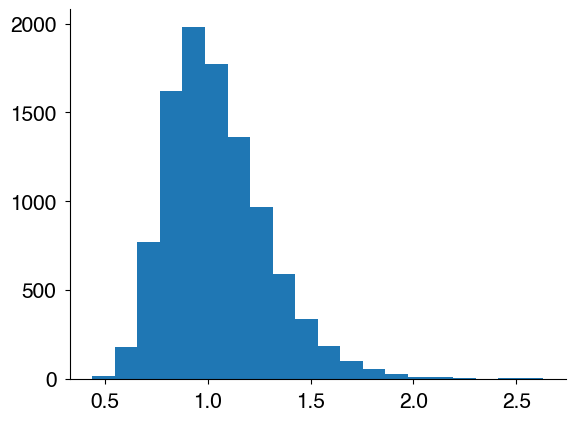

In [42]:
plt.hist(dist.InverseGamma(concentration=20, rate=20).sample(PRNGKey(1), sample_shape=(10000,)), bins=20)

In [24]:
# How do I deal with nans here?

In [25]:
# How do I want this to be used?

# Basically, if you specify a kernel you can easily estimate the relative fitnesses and plot forecasts with uncertainty
# The difficulties are specifying this diag?
# I wonder if I'm better off reimplementing a lot of this myself. 